In [1]:
import pandas as pd
import numpy as np
from preprocessing_unique import create_testdata
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import shap
import pymc3 as pm

/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Normal Model

In [83]:
features_train,windspeed_train,features_test,windspeed_test=create_testdata('200',2)
#seperate out the one-hot encoding variables before standardization 
df1 = features_train.iloc[:, :17]
df2 = features_train.iloc[:, 17:]
df3 = features_test.iloc[:, :17]
df4 = features_test.iloc[:, 17:]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(df1)
dftrain=scaler.transform(df1)
dftest=scaler.transform(df3)

df1=pd.DataFrame(data=dftrain,index=df1.index.values,columns=df1.columns.values)
df3=pd.DataFrame(data=dftest,index=df3.index.values,columns=df3.columns.values)

features_train=pd.concat([df1,df2], axis=1)
features_test=pd.concat([df3,df4], axis=1)

/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
/Users/billyzhaoyh/anaconda/envs/gdal/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [84]:
features_train['y']=windspeed_train
i_variables=[]
number=len(features_train.columns)
for i in range(number-1):
    i_variables.append('X{}'.format(i))
i_variables.append('y')
keys = features_train.columns.values
values = i_variables
dictionary = dict(zip(keys, values))
features_train.rename(columns=dictionary,inplace=True)
features_test.rename(columns=dictionary,inplace=True)
columns=features_train.columns.values
formula='y ~ '+columns[0]
number=len(columns)
for i in range(1, number-1):
    formula=formula+' + '+columns[i]

In [85]:
#Normal Model
with pm.Model() as normal_model:
    
    # The prior for the data likelihood is a Normal Distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = features_train, family = family)
    
    # Perform Markov Chain Monte Carlo sampling letting PyMC3 choose the algorithm
    normal_trace = pm.sample(draws=2000, chains = 3, tune = 500, njobs=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (3 chains in 1 job)
NUTS: [sd, X22, X21, X20, X19, X18, X17, X16, X15, X14, X13, X12, X11, X10, X9, X8, X7, X6, X5, X4, X3, X2, X1, X0, Intercept]
100%|██████████| 2500/2500 [12:28<00:00,  3.27it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 508 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5770839162609055, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 508 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6607581656687098, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reach

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c51590d68>,
      dtype=object)

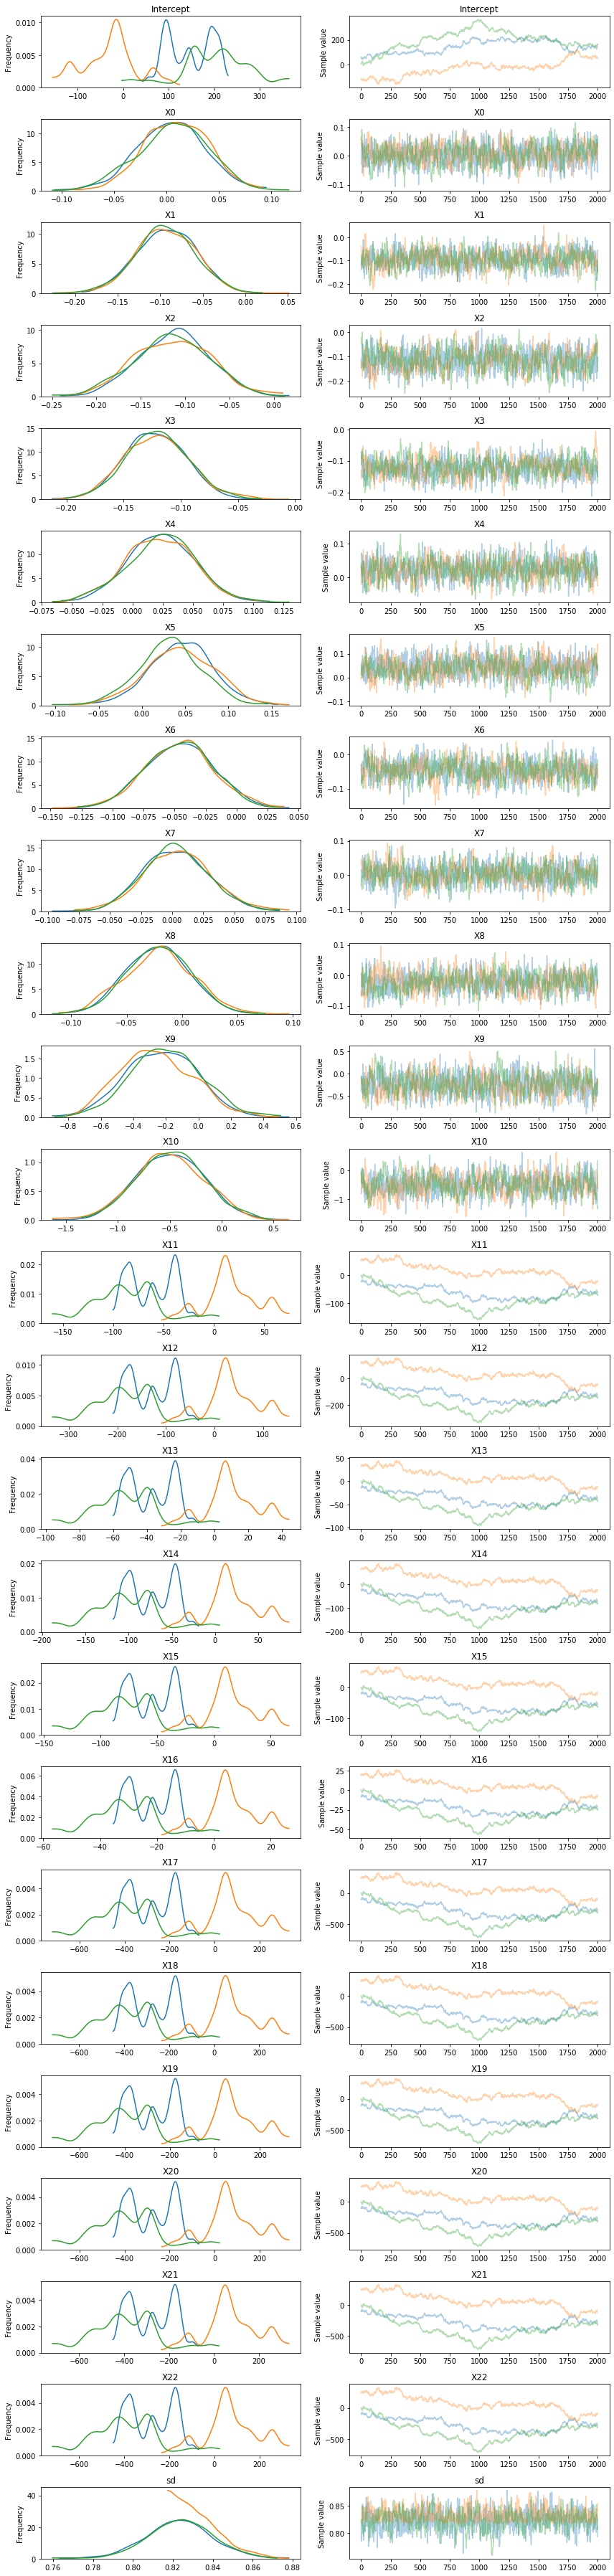

In [86]:
pm.traceplot(normal_trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c5d8a3da0>,
      dtype=object)

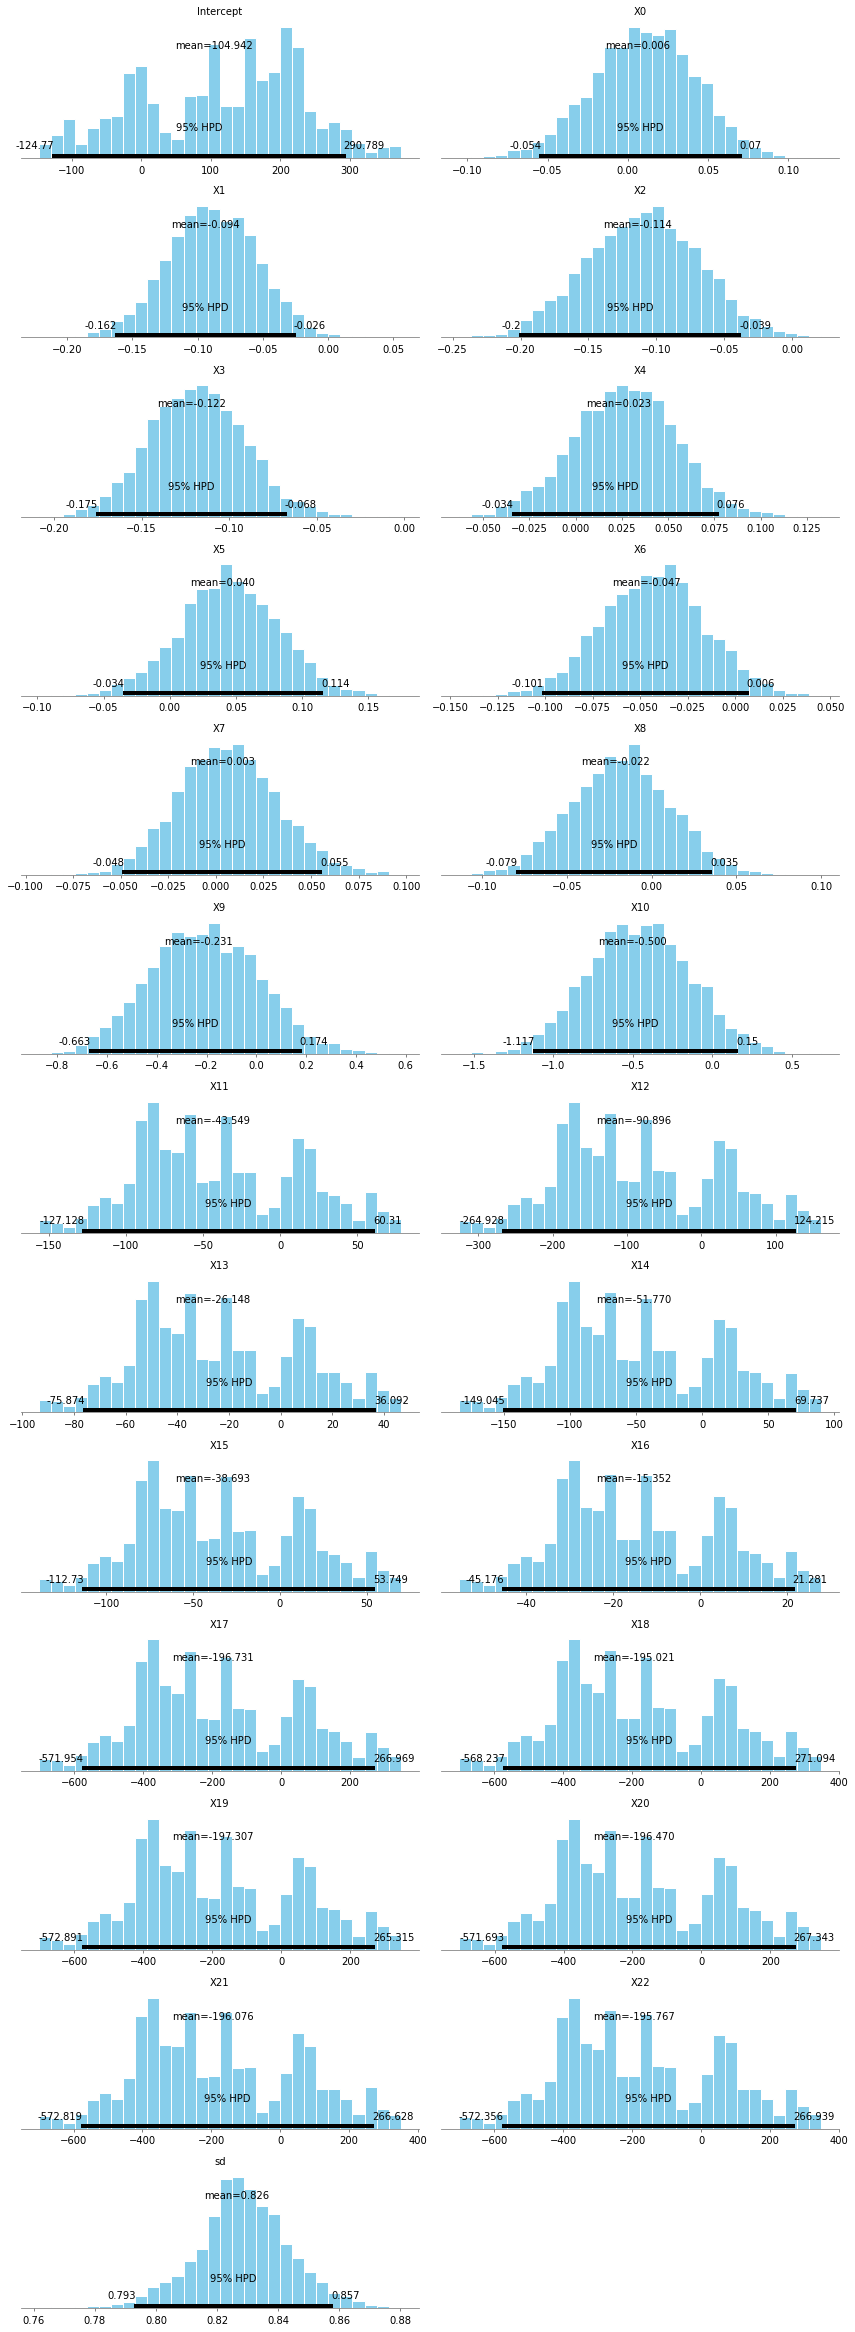

In [87]:
pm.plot_posterior(normal_trace)

In [88]:
model_formula = 'y = '
for variable in normal_trace.varnames:
    model_formula += ' %0.2f * %s +' % (np.mean(normal_trace[variable]), variable)

' '.join(model_formula.split(' ')[:-1])

'y =  104.94 * Intercept + 0.01 * X0 + -0.09 * X1 + -0.11 * X2 + -0.12 * X3 + 0.02 * X4 + 0.04 * X5 + -0.05 * X6 + 0.00 * X7 + -0.02 * X8 + -0.23 * X9 + -0.50 * X10 + -43.55 * X11 + -90.90 * X12 + -26.15 * X13 + -51.77 * X14 + -38.69 * X15 + -15.35 * X16 + -196.73 * X17 + -195.02 * X18 + -197.31 * X19 + -196.47 * X20 + -196.08 * X21 + -195.77 * X22 + -0.19 * sd_log__ + 0.83 * sd'

In [89]:
# Evalute the MCMC trace and compare to ml models
def evaluate_trace(trace, X_train, X_test, y_test):
    
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Means for all the weights
    var_means = var_weights.mean(axis=0)
    
    # Create an intercept column
    X_test['Intercept'] = 1
    
    # Align names of the test observations and means
    names = X_test.columns[1:]
    X_test = X_test.loc[:, names]
    var_means = var_means[names]
    
    # Calculate estimate for each test observation using the average weights
    results = pd.DataFrame(index = X_test.index, columns = ['estimate'])

    for row in X_test.iterrows():
        results.loc[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
        
    # Metrics 
    y_pred=results['estimate']
    #y_pred=scaler.inverse_transform(results['estimate'])
    actual = np.array(windspeed_test)
    #actual = np.array(scaler.inverse_transform(windspeed_test))
    errors =y_pred - actual
    mae = np.mean(abs(errors))
    mse = np.mean(errors ** 2)
    
    print('Model  MAE: {:.4f}\nModel MSE: {:.4f}'.format(mae, mse))
    
    return results

In [90]:
results = evaluate_trace(normal_trace, features_train, features_test, windspeed_test)

Model  MAE: 0.6141
Model MSE: 0.6921


## Robust regression with student t distribution

In [ ]:
#try out robust regression - replace Gaussian distribution with student t distribution
# Context for the model
with pm.Model() as robust_model:
    
    # The prior for the data likelihood is a Normal Distribution
    family = pm.glm.families.StudentT()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = features_train, family = family)
    
    # Perform Markov Chain Monte Carlo sampling letting PyMC3 choose the algorithm
    robust_trace = pm.sample(draws=2000, chains = 2, tune = 500, njobs=-1)

In [ ]:
pm.traceplot(robust_trace)

In [ ]:
pm.plot_posterior(robust_trace)

In [ ]:
model_formula = 'y = '
for variable in robust_trace.varnames:
    model_formula += ' %0.2f * %s +' % (np.mean(robust_trace[variable]), variable)

' '.join(model_formula.split(' ')[:-1])

In [ ]:
results = evaluate_trace(robust_trace, features_train, features_test, windspeed_test)